In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [15]:
df_train = pd.read_csv("../input/covid-19-nlp-text-classification/Corona_NLP_train.csv", encoding="latin1")
df_test = pd.read_csv("../input/covid-19-nlp-text-classification/Corona_NLP_test.csv", encoding="latin1")

# Shuffle DataFrames
df_train = df_train.sample(frac=1)
df_test = df_test.sample(frac=1)

In [16]:
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
23702,27501,72453,NaN,26-03-2020,Ontario premier slams high-end Toronto grocery...,Neutral
1142,4941,49893,"Rome, Lazio",17-03-2020,Christ never abandons us. \r\r\n\r\r\n#COVID?1...,Positive
9590,13389,58341,"Owensboro, KY",20-03-2020,I wonder which place had the most germs right ...,Neutral
37562,41361,86313,"Lahore, Pakistan",10-04-2020,Seen a drop in customer footfall in your groce...,Negative
14583,18382,63334,NaN,21-03-2020,People in grocery stores line up like cattle. ...,Positive


In [17]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
def tokenizer_counter(text, tokenizer):
    return len(tokenizer.encode(text))

tok_len = df_train['OriginalTweet'].apply(lambda x: tokenizer_counter(x, tokenizer))

max(list(tok_len))

184

In [18]:
tokenizer.model_max_length = 200

In [19]:
print(f'Training Dataframe contains {len(df_train)} tweets')
print(f'Test Dataframe contains {len(df_test)} tweets')

Training Dataframe contains 41157 tweets
Test Dataframe contains 3798 tweets


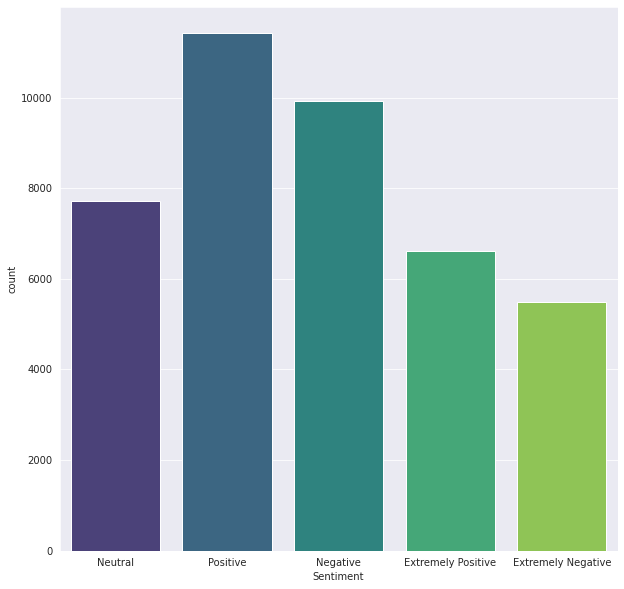

In [20]:
import seaborn as sns
sns.set_style('darkgrid')
plt.figure(figsize = (10,10))
sns.countplot(x = df_train['Sentiment'], palette = 'viridis')
plt.show()

In [21]:
import re
def remove_links(text):
    to_remove = ['\r','\n',',',';',':','.']
    
    out = re.sub(r'http\S+', '', text)
    
    for token in to_remove:
        out = out.replace(token, '')
    
    return re.sub(' +', ' ', out.lower()) #Remove duplicate spaces

def tokenize(text, tokenizer):
    return tokenizer.encode(text, padding='max_length')

name_to_idx = {
    "Extremely Negative" : 0,
    "Negative" : 1,
    "Neutral" : 2,
    "Positive" : 3,
    "Extremely Positive" : 4
}

def process_tgt(value):
    return name_to_idx[value]

In [22]:
train_text = list(df_train["OriginalTweet"].apply(remove_links).apply(lambda x : tokenize(x, tokenizer)))
train_labels = list(df_train["Sentiment"].apply(process_tgt))

test_text = list(df_test["OriginalTweet"].apply(remove_links).apply(lambda x : tokenize(x, tokenizer)))
test_labels = list(df_test["Sentiment"].apply(process_tgt))

In [23]:
from torch.utils.data import Dataset

class CreateDataset(Dataset):
    
    def __init__(self, data, labels):
        
        super().__init__()
        self.data = data
        self.labels = labels
        
    def __getitem__(self, idx):
        
        return torch.tensor(self.data[idx]), torch.tensor(self.labels[idx])
    
    def __len__(self):
        return len(self.labels)
    
    
train_dataset = CreateDataset(train_text, train_labels)
test_dataset = CreateDataset(test_text, test_labels)

In [24]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, shuffle = True, batch_size = 32)
test_loader = DataLoader(test_dataset, shuffle = True, batch_size = 32)

In [25]:
class LSTMModel(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            input_size = embedding_dim,
            hidden_size = hidden_size,
            num_layers = num_layers,
            dropout = dropout,
            batch_first = True,
            bidirectional = True
                           )
        self.linear = nn.Linear(512 * 200, 5)
    
    def forward(self, inputs):
        emb = self.embedding(inputs)
        lstm_out, _ = self.lstm(emb)
        output = self.linear(lstm_out.reshape(lstm_out.size()[0], -1))
        return output
    
model = LSTMModel(tokenizer.vocab_size, 256, 256, 4, 0.2)

In [37]:
from tqdm import tqdm

class Trainer():
    
    def __init__(self, model, train_loader, valid_loader):
        
        self.model = model
        self.train_loader = train_loader
        self.valid_loader = valid_loader

    def train_epoch(self, f_loss, optimizer, device):

        # We enter train mode. This is useless for the linear model
        # but is important for layers such as dropout, batchnorm, ...
        self.model.train()

        correct = 0
        tot_loss = 0
        N = 41157 # Dataset length

        # iterator = tqdm(enumerate(self.train_loader))
        iterator = enumerate(self.train_loader)

        for i, (inputs, targets) in iterator:
            inputs, targets = inputs.to(device), targets.to(device)

            # Compute the forward pass through the network up to the loss
            outputs = self.model(inputs)

            loss = f_loss(outputs, targets)

            loss_value = loss.item()

            # Backward and optimize

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            tot_loss += inputs.shape[0] * loss_value

            predicted_targets = outputs.argmax(dim=1)
            correct += (predicted_targets == targets).sum().item()

            #iterator.set_description("loss : {: .3f} | accuracy : {: .3f}".format(tot_loss/(inputs.shape[0]*(i+1)), correct/(inputs.shape[0]*(i+1))))

        return tot_loss/N, correct/N

    def valid_epoch(self, f_loss, device):
        # We enter train mode. This is useless for the linear model
        # but is important for layers such as dropout, batchnorm, ...
        self.model.eval()

        correct = 0
        tot_loss = 0
        N = 3798 # Dataset length

        # iterator = tqdm(enumerate(self.valid_loader))
        iterator = enumerate(self.valid_loader)

        with torch.no_grad():
            for i, (inputs, targets) in iterator:
                inputs, targets = inputs.to(device), targets.to(device)

                # Compute the forward pass through the network up to the loss
                outputs = self.model(inputs)

                loss = f_loss(outputs, targets)

                tot_loss += inputs.shape[0] * loss.item()

                predicted_targets = outputs.argmax(dim=1)
                correct += (predicted_targets == targets).sum().item()

                # iterator.set_description("loss : {: .3f} | accuracy : {: .3f}".format(tot_loss/(inputs.shape[0]*(i+1)), correct/(inputs.shape[0]*(i+1))))

        return tot_loss/N, correct/N

    def training(self, f_loss, optimizer, device, epochs = 10):

        train_loss = []
        train_acc = []
        valid_loss = []
        valid_acc = []

        for i in range(epochs):
            print("EPOCH {}/{}".format(i + 1, epochs))
            train_results = self.train_epoch(f_loss, optimizer, device)
            print("Training loss : {: .3f} | Training accuracy : {: .3f}".format(*train_results))
            valid_results = self.valid_epoch(f_loss, device)
            print("Validation loss : {: .3f} | Validation accuracy : {: .3f}\n".format(*valid_results))

            train_loss.append(train_results[0])
            train_acc.append(train_results[1])
            valid_loss.append(valid_results[0])
            valid_acc.append(valid_results[1])

        return train_loss, train_acc, valid_loss, valid_acc

In [38]:
device = torch.device('cuda')
model = model.cuda()

f_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [39]:
trainer = Trainer(model, train_loader, test_loader)

train_loss, train_acc, valid_loss, valid_acc = trainer.training(f_loss, optimizer, device, epochs = 8)

EPOCH 1/8
Training loss :  1.213 | Training accuracy :  0.490
Validation loss :  0.959 | Validation accuracy :  0.645

EPOCH 2/8
Training loss :  0.737 | Training accuracy :  0.726
Validation loss :  0.751 | Validation accuracy :  0.726

EPOCH 3/8
Training loss :  0.484 | Training accuracy :  0.828
Validation loss :  0.705 | Validation accuracy :  0.761

EPOCH 4/8
Training loss :  0.306 | Training accuracy :  0.895
Validation loss :  0.753 | Validation accuracy :  0.764

EPOCH 5/8
Training loss :  0.194 | Training accuracy :  0.934
Validation loss :  0.899 | Validation accuracy :  0.759

EPOCH 6/8
Training loss :  0.135 | Training accuracy :  0.955
Validation loss :  1.074 | Validation accuracy :  0.772

EPOCH 7/8
Training loss :  0.101 | Training accuracy :  0.967
Validation loss :  1.081 | Validation accuracy :  0.773

EPOCH 8/8
Training loss :  0.083 | Training accuracy :  0.973
Validation loss :  1.329 | Validation accuracy :  0.773



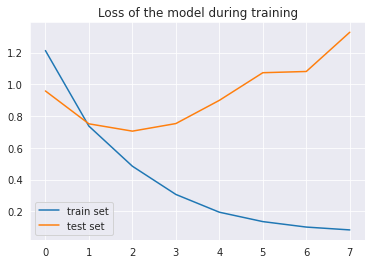

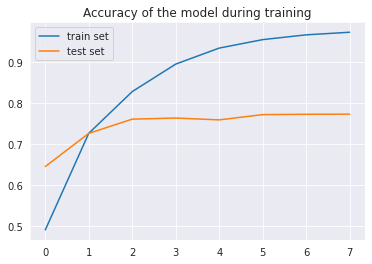

In [40]:
plt.plot(train_loss, label = "train set")
plt.plot(valid_loss, label = "test set")
plt.legend()
plt.title("Loss of the model during training")
plt.show()

plt.plot(train_acc, label = "train set")
plt.plot(valid_acc, label = "test set")
plt.legend()
plt.title("Accuracy of the model during training")
plt.show()